<a href="https://colab.research.google.com/github/yoshimethod/bioinformatics/blob/main/bioinformatics_pr7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install git+https://github.com/hmdlab/raptgen.git@v1.0.0
!sudo apt-get install fonts-noto-cjk
!pip install biopython CairoSVG svgwrite GPy==1.9.9 GPyOpt==1.2.6 scipy==1.4.1

  Cloning https://github.com/hmdlab/raptgen.git (to revision v1.0.0) to /tmp/pip-req-build-hrdpwtwq
  Running command git clone --filter=blob:none --quiet https://github.com/hmdlab/raptgen.git /tmp/pip-req-build-hrdpwtwq
  Running command git checkout -q bc2f2a58043593c0000b954fba5989a270393c5f
  Resolved https://github.com/hmdlab/raptgen.git to commit bc2f2a58043593c0000b954fba5989a270393c5f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for raptgen: filename=raptgen-0.1.0-py3-none-any.whl size=22953 sha256=40b579594723c6d97bd7e62d4556b9b4ed455175029ef6601c45d6ae860e27dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-z5i4acr4/wheels/b0/fe/17/1450a3b2a5dd9e6c1ee8eeaa1e9a27d9f92152a79f509a40ed
Successfully built raptgen
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packag

In [2]:
skip_heavy_computation = True

if skip_heavy_computation:
  reload_model = True
else:
  reload_model = False

In [3]:
!wget https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/data/simulation/paired/sequences.txt

--2024-06-07 07:06:39--  https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/data/simulation/paired/sequences.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165000 (161K) [text/plain]
Saving to: ‘sequences.txt’

sequences.txt       100%[===================>] 161.13K  --.-KB/s    in 0.005s  

2024-06-07 07:06:39 (31.9 MB/s) - ‘sequences.txt’ saved [165000/165000]



In [4]:
!head sequences.txt

1,AAAAACATACCACACTACTGTTCTTGGGGG
0,AAAAAAACACTACCTATCCCTCTAAGGGGG
0,AAAAACACTACTCGCGCCCTCTGTGGGGGG
2,AAAAATGTACTACACCCCTCGGATAGGGGG
0,AAAAACGAAGACTACTGCCCTCGTAGGGGG
0,AAAAAGCACTACTCGGTCCCTCTTAGGGGG
0,AAAAATTATACTACCATATCCCTCCGGGGG
0,AAAAAATCAGACTACCTCCCCCTCTGGGGG
0,AAAAAGATACACTACTGTCCCTCTGGGGGG
0,AAAAAGACTACAACCCTCGACTACAGGGGG


In [6]:
!pip install biopython

  Using cached biopython-1.83-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


In [7]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pathlib import Path

In [8]:
with Path('sequences.txt').open() as f:
  records = []
  for idx, line in enumerate(f.readlines()):
    motif_idx, sequence = line.strip().split(',')
    record = SeqRecord(
        Seq(sequence),
        id = f'{idx}',
        description = f"motif:{motif_idx} #{idx}"
    )

    records.append(record)

  SeqIO.write(
      sequences = records,
      handle ='sample.fasta',
      format = 'fasta'
  )

In [9]:
!head -n 4 sample.fasta

>0 motif:1 #0
AAAAACATACCACACTACTGTTCTTGGGGG
>1 motif:0 #1
AAAAAAACACTACCTATCCCTCTAAGGGGG


In [14]:
from raptgen.data import SingleRound
filename = 'sample.fasta'
single_round =SingleRound(path = filename)

In [21]:
import torch

epochs = 200
threshold = 10
device = "cuda"

if device == "cuda" and torch.cuda.is_available() == False:
  print("cuda is not available. using cpu.")
  device = torch.device("cpu")
else:
  print(f"using {device}.")
  device = torch.device(device)

min_count = 1

train_loader, test_loader = single_round.get_dataloader(
    min_count = min_count, use_cuda = (device == torch.device("cuda"))
)

force_epochs = 10
save_dir = "out/"
save_dir = Path(save_dir).expanduser()
save_dir.mkdir(exist_ok = True, parents = True)

using cuda.


In [22]:
from raptgen.models import CNN_PHMM_VAE

model = CNN_PHMM_VAE(
    motif_len = single_round.random_region_length,
    embed_size = 2
)

model = model.to(device)

from torch import optim
optimizer = optim.Adam(model.parameters())

train_kwargs = {
    "epochs" : epochs,
    "threshold" : threshold,
    "device" : device,
    "train_loader" : train_loader,
    "test_loader" : test_loader,
    "save_dir" : save_dir,
    "beta_schedule" : True,
    "force_matching" : True,
    "force_epochs" : force_epochs,
    "model" : model,
    "optimizer" : optimizer,
    "model_str" : "cnn_phmm_vae.mdl",
}

In [23]:
from raptgen.models import train
if not skip_heavy_computation:
  train_result = train(**train_kwargs)

In [24]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [10,2.5]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['savefig.bbox'] = 'tight'

from matplotlib import pyplot as plt
from raptgen.visualization import write_profile_hmm_svg

if reload_model:
  model = CNN_PHMM_VAE(
      motif_len = single_round.random_region_length,
      embed_size = 2
  )

  !wget https://github.com/hmdlab/raptgen/raw/v1.0.0/results/simulation/paired/cnn_phmm_vae.mdl

  model.load_state_dict(torch.load('cnn_phmm_vae.mdl', map_location = device))

--2024-06-07 07:56:19--  https://github.com/hmdlab/raptgen/raw/v1.0.0/results/simulation/paired/cnn_phmm_vae.mdl
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/results/simulation/paired/cnn_phmm_vae.mdl [following]
--2024-06-07 07:56:20--  https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/results/simulation/paired/cnn_phmm_vae.mdl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 901980 (881K) [application/octet-stream]
Saving to: ‘cnn_phmm_vae.mdl’

cnn_phmm_vae.mdl    100%[===================>] 880.84K  --.-KB/s    in 0.008s  

2024-06-07 07:56:20 (115 MB/s) - ‘c

In [25]:
from raptgen.data import Result

result = Result(
    model.to('cpu'),
    experiment = single_round,
    path_to_save_results = save_dir,
    load_if_exists = True
)

sequences = single_round.get_filter_passed_sequences(
    random_only = True
)

embed_x = result.embed_sequences(sequences)

In [26]:
with Path('sequences.txt').open() as f:
  l = []
  for line in f.readlines():
    motif_idx_str, sequence = line.strip().split(',')
    l.append(int(motif_idx_str))

len(l)

5000

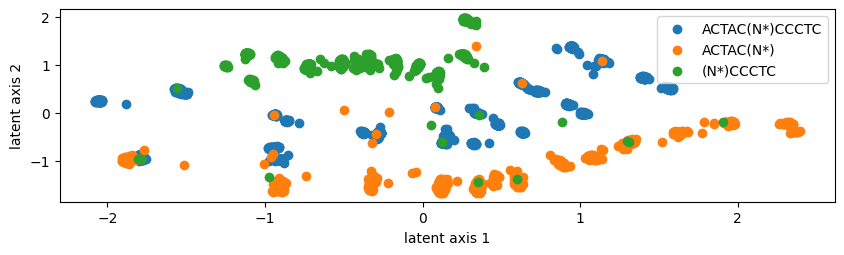

In [29]:
fig, ax = plt.subplots()

x1, x2 = embed_x.T.detach().numpy()

labels = [
    "ACTAC(N*)CCCTC",
    "ACTAC(N*)",
    "(N*)CCCTC"
]

for i in range(3):
  _x = [x for x, motif_id in zip(x1, l) if motif_id == i]
  _y = [x for x, motif_id in zip(x2, l) if motif_id == i]

  ax.scatter(
      _x,
      _y,
      label = labels[i]
      )

plt.xlabel('latent axis 1')
plt.ylabel('latent axis 2')
plt.legend()
plt.show()

In [37]:
!pip3 install cairosvg
!pip3 install svgwrite
import cairosvg

  Using cached svgwrite-1.4.3-py3-none-any.whl (67 kB)


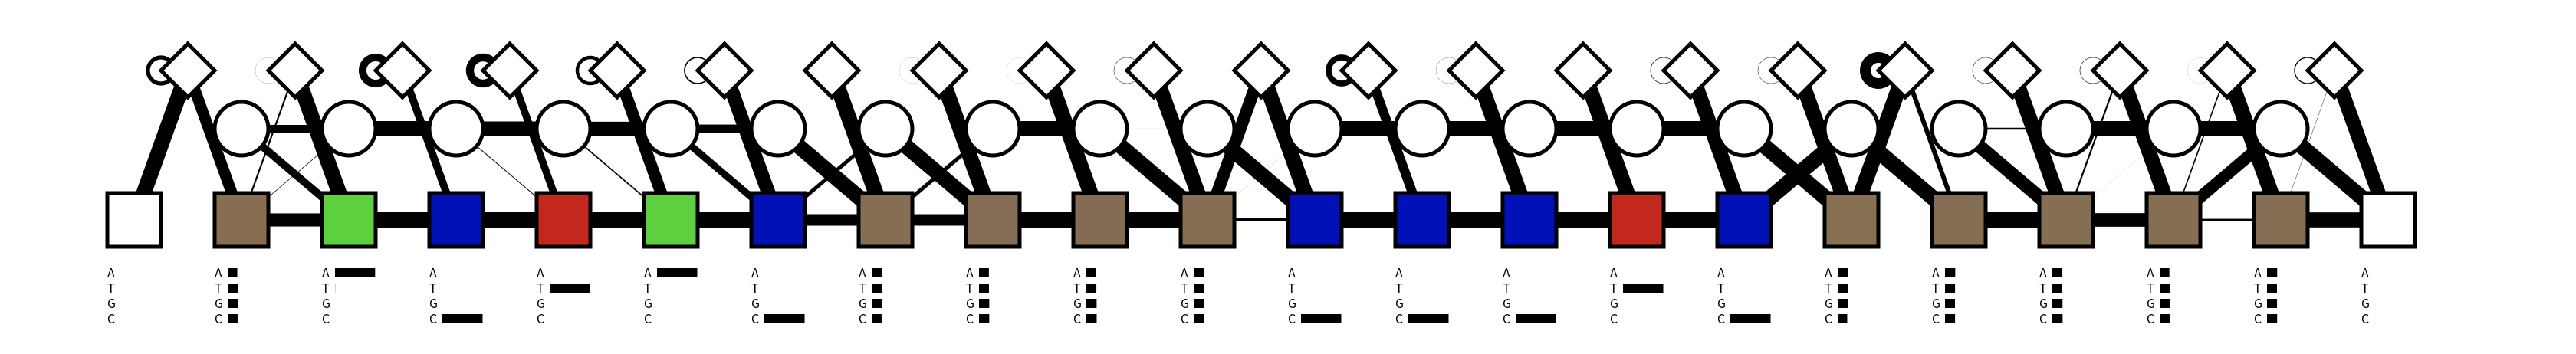

In [38]:
x = torch.Tensor([[0, 0]])

(a, e_m) = model.decoder(x)

a = a[0].detach().numpy()
e_m = e_m[0].detach().numpy()

write_profile_hmm_svg(a, e_m, savepng = True)

from PIL import Image
Image.open('profile_HMM.png')

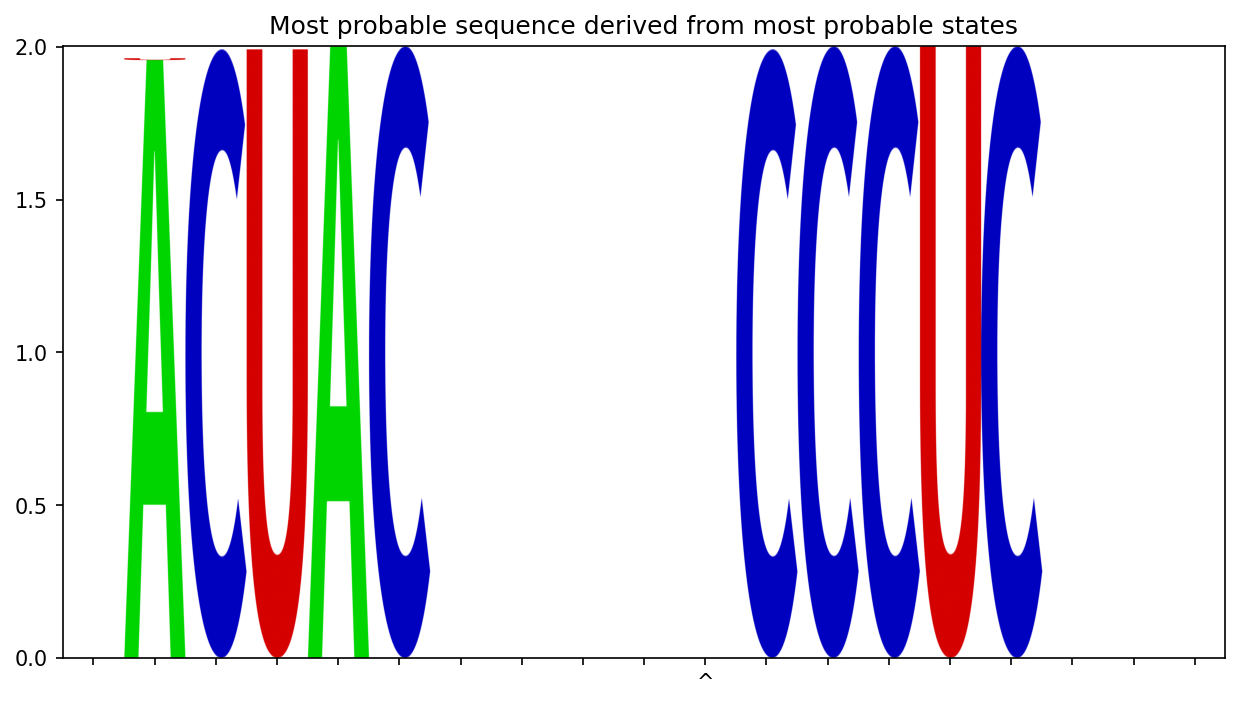

In [39]:
from raptgen.visualization import draw_most_probable

draw_most_probable(a, e_m, force = True)

In [41]:
from raptgen.data import ProfileHMMSampler

sampler = ProfileHMMSampler(a, e_m, proba_is_log = True)

In [42]:
sampler.sample(sequence_only = True)

'tTACTACATTAgCCCTC_GACA'

In [43]:
!wget https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/data/real/A_4R.fastq
!wget https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/results/real/A_best.mdl
!wget https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/results/real/A_evaled.csv

--2024-06-07 08:30:24--  https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/data/real/A_4R.fastq
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15694590 (15M) [text/plain]
Saving to: ‘A_4R.fastq’

A_4R.fastq          100%[===================>]  14.97M  --.-KB/s    in 0.04s   

2024-06-07 08:30:25 (390 MB/s) - ‘A_4R.fastq’ saved [15694590/15694590]

--2024-06-07 08:30:26--  https://raw.githubusercontent.com/hmdlab/raptgen/v1.0.0/results/real/A_best.mdl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 916452 (895K) [application

In [45]:
experiment = SingleRound(path = 'A_4R.fastq')
model = CNN_PHMM_VAE(experiment.random_region_length, embed_size = 2)
model.load_state_dict(torch.load('A_best.mdl', map_location = device))
result = Result(
    model,
    experiment = experiment,
    path_to_save_results = save_dir,
    load_if_exists = True
)

In [49]:
!pip install GPy
!pip install GPyOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 15.2 MB/s eta 0:00:00
  Using cached GPyOpt-1.2.6.tar.gz (56 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=19456a12746c074b9291d5c21433b597f5e04309d2578854fb07c9e5a8080f61
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
Successfully built GPyOpt


In [57]:
import pandas as pd

df = pd.read_csv('A_evaled.csv', names = ['seq', 'activity'])
seq, act = df.values.T
result.evaluated_X = result.embed_sequences(seq)
result.evaluated_y = -act[:, None]

locations = result.get_bo_result(force_rerun = True)
locations

TypeError: 'float' object is not subscriptable

TypeError: 'float' object is not subscriptable

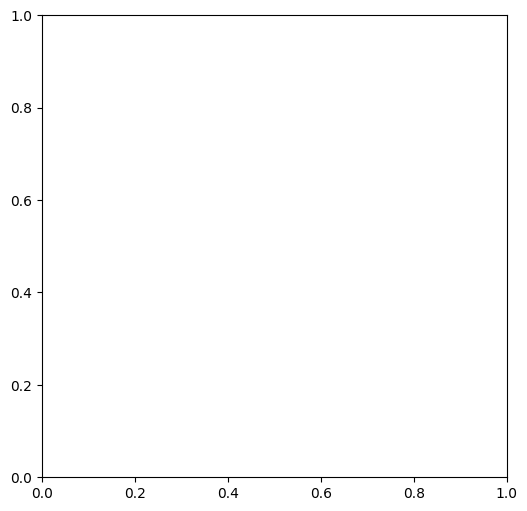

In [58]:
fig, ax = plt.subplots(figsize = (6, 6))
result.plot_bo(ax, fig)
ax.set_xlabel('latent axis 1')
ax.set_ylabel('latent axis 2')
ax.legend()
plt.show()